In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.manifold import TSNE

from utils import get_data, calc_reconstruction_error

# sns.set_theme(rc={'figure.figsize':(11.7,8.27)})

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
X = pd.read_csv('data/CC GENERAL.csv')
X.drop(columns=['CUST_ID'], inplace=True)
X.ffill(inplace=True)
X.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,627.284787,0.000000,12
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [3]:
X.shape

(8950, 17)

In [4]:
# Split data into train and test sets.

TEST_SIZE = 0.2
RANDOM_STATE = 42

X_train, X_test, _, _ = train_test_split(X, X, test_size=TEST_SIZE, random_state=RANDOM_STATE)

# Apply PCA

In [5]:
RANDOM_STATE = 42
PCA_N_COMPONENTS = 17

scaler = StandardScaler()
dim_redn = PCA(n_components=PCA_N_COMPONENTS, random_state=RANDOM_STATE)

dr_pipeline = Pipeline(steps=[
    ('scaler', scaler),
    ('dim_redn', dim_redn)
])


In [6]:
dr_pipeline.fit(X_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('dim_redn', PCA(n_components=17, random_state=42))])

In [7]:
# # Sanity check to see that the explianed variance does not change with the n_components param
# for n_components in range(1, 11):
#     dim_redn = PCA(n_components=n_components, random_state=RANDOM_STATE)
#     dr_pipeline = Pipeline(steps=[
#         ('scaler', scaler),
#         ('dim_redn', dim_redn)
#     ])
#     dr_pipeline.fit(X_train)
#     print(f"n_components: {n_components}, Explained Variance: {dr_pipeline['dim_redn'].explained_variance_ratio_}")

<Axes: title={'center': 'Explained Variance by Number of Components'}, xlabel='n_components'>

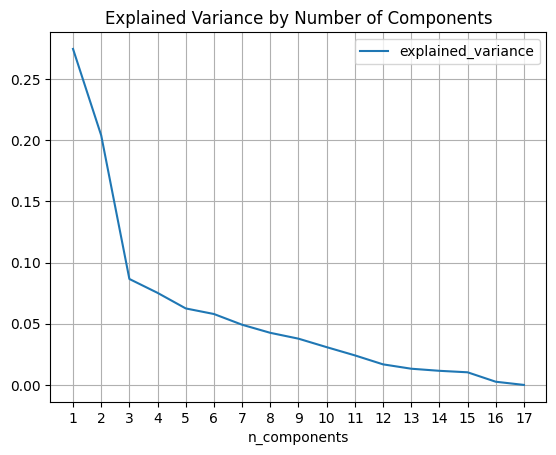

In [8]:
expl_var = pd.DataFrame({'n_components': range(1, PCA_N_COMPONENTS+1), 
'explained_variance': dr_pipeline.named_steps['dim_redn'].explained_variance_ratio_})

expl_var.plot(x='n_components', y='explained_variance', title='Explained Variance by Number of Components', xticks=expl_var['n_components'], grid=True)

In [9]:
# Calculate the reconstruction error for different number of components
pca_recon_err = {}
for n_components in range(1, PCA_N_COMPONENTS+1):
    dr_pipeline = Pipeline(steps=[
        ('scaler', scaler),
        ('dim_redn', PCA(n_components=n_components, random_state=RANDOM_STATE))
    ])
    
    X_transformed = dr_pipeline.fit_transform(X_train)
    X_reconstructed = dr_pipeline.inverse_transform(X_transformed)

    reconstruction_error = calc_reconstruction_error(X_train, X_reconstructed)
    print(f'PCA with {n_components} components has a reconstruction error of {reconstruction_error:.2f}')
    pca_recon_err[n_components] = reconstruction_error


PCA with 1 components has a reconstruction error of 33485110.97
PCA with 2 components has a reconstruction error of 22516938.08
PCA with 3 components has a reconstruction error of 19850323.38
PCA with 4 components has a reconstruction error of 17224418.86
PCA with 5 components has a reconstruction error of 15225338.65
PCA with 6 components has a reconstruction error of 12762085.89
PCA with 7 components has a reconstruction error of 8386364.22
PCA with 8 components has a reconstruction error of 6063341.75
PCA with 9 components has a reconstruction error of 5365903.23
PCA with 10 components has a reconstruction error of 3790086.24
PCA with 11 components has a reconstruction error of 2855217.50
PCA with 12 components has a reconstruction error of 1531516.70
PCA with 13 components has a reconstruction error of 1082243.78
PCA with 14 components has a reconstruction error of 192184.49
PCA with 15 components has a reconstruction error of 354.00
PCA with 16 components has a reconstruction erro

<Axes: title={'center': 'Reconstruction Error by Number of Components'}, xlabel='n_components'>

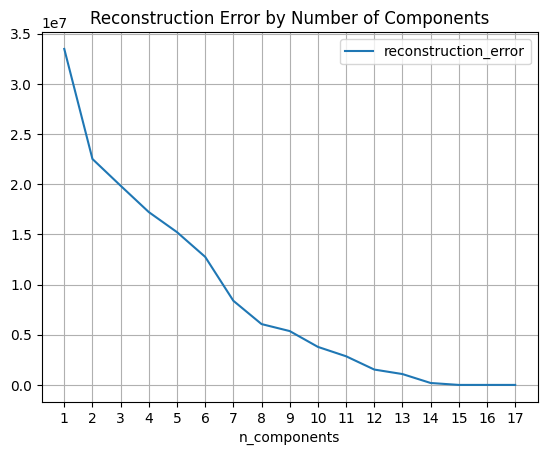

In [10]:
pca_recon_err_df = pd.DataFrame(pca_recon_err.items(), columns=['n_components', 'reconstruction_error'])
pca_recon_err_df.plot(x='n_components', y='reconstruction_error', title='Reconstruction Error by Number of Components', xticks=pca_recon_err_df['n_components'], grid=True)

# Apply ICA

In [11]:
RANDOM_STATE = 42

scaler = StandardScaler()
dim_redn = FastICA(random_state=RANDOM_STATE)

dr_pipeline = Pipeline(steps=[
    ('scaler', scaler),
    ('dim_redn', dim_redn)
])


In [12]:
results = []
ica_recon_err = {}
for n_components in range(1, X_train.shape[1]+1):
    print(f"---------- n_components: {n_components} ----------")
    dr_pipeline.set_params(dim_redn__n_components=n_components)

    X_transformed = dr_pipeline.fit_transform(X_train)
    
    res = stats.kurtosistest(X_transformed)
    res.statistic, res.pvalue
    
    results.append(pd.DataFrame({'n_components': [n_components]*n_components,
                            'component': np.arange(1, n_components+1),
                             'kurtosis_stat': res.statistic,
                             'kurtosis_pvalue': res.pvalue}
                           ))
    
    X_reconstructed = dr_pipeline.inverse_transform(X_transformed)
    reconstruction_error = calc_reconstruction_error(X_train, X_reconstructed)

    print(f'ICA with {n_components} components has a reconstruction error of {reconstruction_error:.2f}')
    ica_recon_err[n_components] = reconstruction_error


---------- n_components: 1 ----------
ICA with 1 components has a reconstruction error of 33485110.97
---------- n_components: 2 ----------
ICA with 2 components has a reconstruction error of 22516934.24
---------- n_components: 3 ----------
ICA with 3 components has a reconstruction error of 19850301.67
---------- n_components: 4 ----------
ICA with 4 components has a reconstruction error of 17224337.68
---------- n_components: 5 ----------
ICA with 5 components has a reconstruction error of 15225338.64
---------- n_components: 6 ----------
ICA with 6 components has a reconstruction error of 12762085.89
---------- n_components: 7 ----------
ICA with 7 components has a reconstruction error of 8386364.22
---------- n_components: 8 ----------
ICA with 8 components has a reconstruction error of 6063341.75
---------- n_components: 9 ----------
ICA with 9 components has a reconstruction error of 5365903.23
---------- n_components: 10 ----------
ICA with 10 components has a reconstruction er

In [13]:
results_df  = pd.concat(results)

<Axes: xlabel='component', ylabel='kurtosis_stat'>

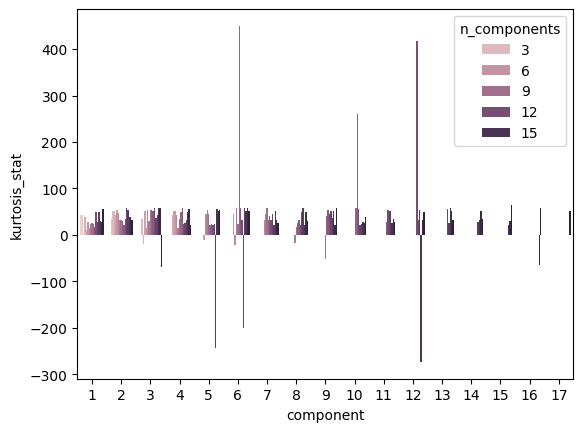

In [14]:
sns.barplot(x='component', y='kurtosis_stat', data=results_df, hue='n_components')

<Axes: xlabel='n_components', ylabel='kurtosis_stat'>

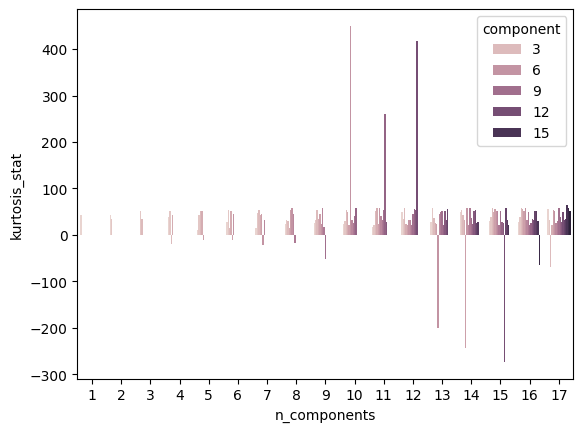

In [15]:
sns.barplot(x='n_components', y='kurtosis_stat', data=results_df, hue='component')

<Axes: xlabel='component', ylabel='kurtosis_pvalue'>

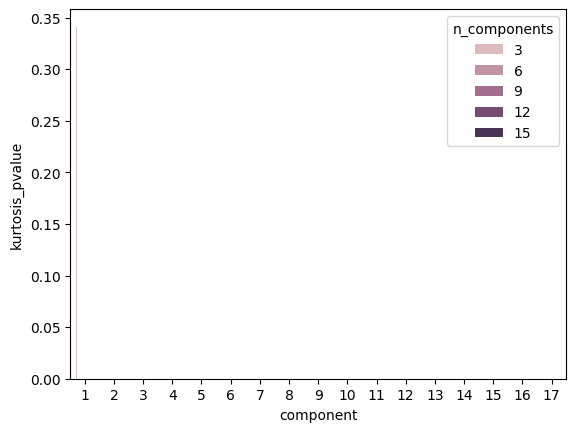

In [16]:
sns.barplot(x='component', y='kurtosis_pvalue', data=results_df, hue='n_components')

<Axes: xlabel='component', ylabel='kurtosis_pvalue'>

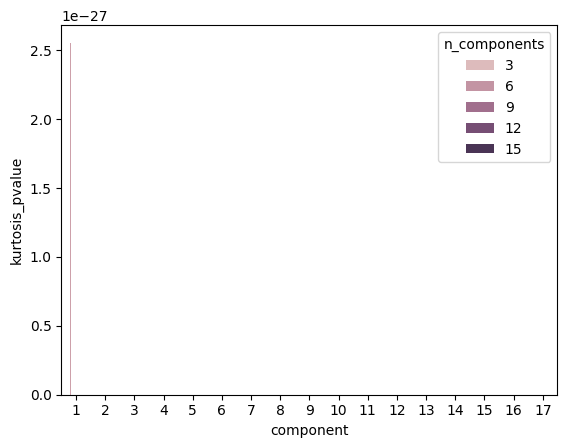

In [17]:
sns.barplot(x='component', y='kurtosis_pvalue', data=results_df.query('kurtosis_pvalue < 0.0001'), hue='n_components')

<Axes: title={'center': 'Reconstruction Error by Number of Components'}, xlabel='n_components'>

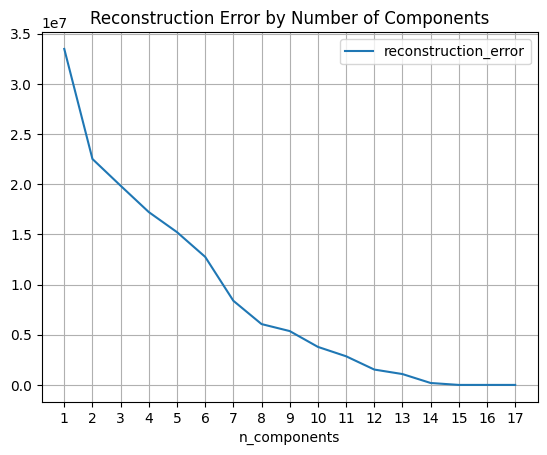

In [18]:
ica_recon_err_df = pd.DataFrame(ica_recon_err.items(), columns=['n_components', 'reconstruction_error'])
ica_recon_err_df.plot(x='n_components', y='reconstruction_error', title='Reconstruction Error by Number of Components', xticks=ica_recon_err_df['n_components'], grid=True)

# Apply Gaussian projection

In [19]:
RANDOM_STATE = 42

scaler = StandardScaler()
dim_redn = GaussianRandomProjection(random_state=RANDOM_STATE)

dr_pipeline = Pipeline(steps=[
    ('scaler', scaler),
    ('dim_redn', dim_redn)
])

In [20]:
# reconstruction error
rand_proj_recon_err = {}
for n_components in range(1, X_train.shape[1]+1):
    print(f"---------- n_components: {n_components} ----------")
    dr_pipeline.set_params(dim_redn__n_components=n_components)

    X_transformed = dr_pipeline.fit_transform(X_train)
    X_reconstructed = dr_pipeline.inverse_transform(X_transformed)
    reconstruction_error = calc_reconstruction_error(X_train, X_reconstructed)

    print(f'GaussRandProj with {n_components} components has a reconstruction error of {reconstruction_error:.2f}')
    rand_proj_recon_err[n_components] = reconstruction_error


---------- n_components: 1 ----------
GaussRandProj with 1 components has a reconstruction error of 41731392.08
---------- n_components: 2 ----------
GaussRandProj with 2 components has a reconstruction error of 39823452.08
---------- n_components: 3 ----------
GaussRandProj with 3 components has a reconstruction error of 39764645.72
---------- n_components: 4 ----------
GaussRandProj with 4 components has a reconstruction error of 35389440.46
---------- n_components: 5 ----------
GaussRandProj with 5 components has a reconstruction error of 30740759.30
---------- n_components: 6 ----------
GaussRandProj with 6 components has a reconstruction error of 30513662.15
---------- n_components: 7 ----------
GaussRandProj with 7 components has a reconstruction error of 30449218.91
---------- n_components: 8 ----------
GaussRandProj with 8 components has a reconstruction error of 29700097.28
---------- n_components: 9 ----------
GaussRandProj with 9 components has a reconstruction error of 2791

<Axes: title={'center': 'Reconstruction Error by Number of Components'}, xlabel='n_components'>

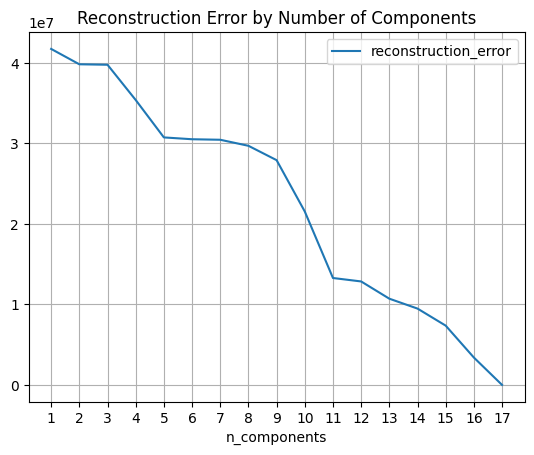

In [21]:
rand_proj_recon_err = pd.DataFrame(rand_proj_recon_err.items(), columns=['n_components', 'reconstruction_error'])
rand_proj_recon_err.plot(x='n_components', y='reconstruction_error', title='Reconstruction Error by Number of Components', xticks=rand_proj_recon_err['n_components'], grid=True)

# Apply t-SNE

In [22]:
RANDOM_STATE = 42

scaler = StandardScaler()
dim_redn = TSNE(random_state=RANDOM_STATE)

dr_pipeline = Pipeline(steps=[
    ('scaler', scaler),
    ('dim_redn', dim_redn)
])

In [24]:

tsne_kl_divergence = {}
for n_components in range(1, 4):
    print(f"---------- n_components: {n_components} ----------")
    dr_pipeline.set_params(dim_redn__n_components=n_components)

    dr_pipeline.fit(X_train)
    
    kl_divergence = dr_pipeline.named_steps['dim_redn'].kl_divergence_

    print(f'TSNE with {n_components} components has a kl_divergence of {kl_divergence:.2f}')
    tsne_kl_divergence[n_components] = kl_divergence

---------- n_components: 1 ----------


c:\Users\pavan\anaconda3\envs\ml\Lib\site-packages\daal4py\sklearn\manifold\_t_sne.py:396: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


TSNE with 1 components has a kl_divergence of 2.38
---------- n_components: 2 ----------


c:\Users\pavan\anaconda3\envs\ml\Lib\site-packages\daal4py\sklearn\manifold\_t_sne.py:396: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


TSNE with 2 components has a kl_divergence of 1.58
---------- n_components: 3 ----------


c:\Users\pavan\anaconda3\envs\ml\Lib\site-packages\daal4py\sklearn\manifold\_t_sne.py:396: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


TSNE with 3 components has a kl_divergence of 1.25


<Axes: title={'center': 'KL Divergence by Number of Components'}, xlabel='n_components'>

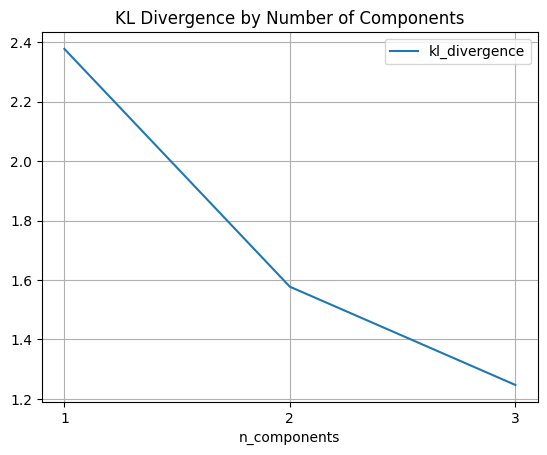

In [26]:
tsne_kl_divergence_df  = pd.DataFrame(tsne_kl_divergence.items(), columns=['n_components', 'kl_divergence'])
tsne_kl_divergence_df.plot(x='n_components', y='kl_divergence', title='KL Divergence by Number of Components', xticks=tsne_kl_divergence_df['n_components'], grid=True)